In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.lib.stride_tricks import sliding_window_view

In [4]:
def scaled_trainer(arr, lb, lf, choice):
    tx = np.array([])
    ty = np.array([])
    t = np.array([])
    tx_new = np.array([])

    for i in arr:
        data = pd.read_csv(i).filter([choice]).values
        #data = sc.fit_transform(data)
        t = np.append(t, sliding_window_view(data, window_shape = (lb+lf,1)))

    t = t.reshape(int(t.shape[0]/(lb+lf)), lb+lf)
    for j in t:
    #j = 10*(j)/max(abs(j))
        tx = np.append(tx, j[:lb])
        ty = np.append(ty, j[lb:])
    tx = tx.reshape((int(tx.shape[0]/lb), lb))
    
    for k in tx:
            #increase = (k[a+1]-k[a])/k[a]
        increase = np.diff(k)/k[:-1]
        tx_new = np.append(tx_new, increase)
    tx_new = tx_new.reshape((int(tx_new.shape[0]/(lb-1)), (lb-1)))
    ty = ty.reshape((int(ty.shape[0]/lf), lf))

    return tx_new, ty

In [5]:
lb=51
lf=3
companies = ["asian paints.csv"]

print("Starting...")
open_x, open_y = scaled_trainer(companies, lb, lf, "Open Price")
print("Completed 1/5...")
high_x, high_y = scaled_trainer(companies, lb, lf, "High Price")
print("Completed 2/5...")
low_x, low_y = scaled_trainer(companies, lb, lf, "Low Price")
print("Completed 3/5...")
close_x, close_y = scaled_trainer(companies, lb, lf, "Close Price")
print("Completed 4/5...")
wap_x, wap_y = scaled_trainer(companies, lb, lf, "WAP")
print("Completed 5/5...")
wap_x.shape

Starting...
Completed 1/5...
Completed 2/5...
Completed 3/5...
Completed 4/5...
Completed 5/5...


(5481, 50)

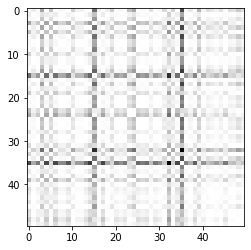

(50, 50)

In [6]:
x = open_x[1310]

eps = 0.1
d = np.abs(np.subtract.outer(x,x))
R = np.exp(-d**2/eps)

# Plot the recurrence matrix
plt.imshow(R, cmap='gray', interpolation='nearest')
plt.show()
R.shape

In [7]:
wap_img = np.array([])
for i in wap_x:
    eps = 0.1
    d = np.abs(np.subtract.outer(i,i))
    R = np.exp(-d**2/eps)
    wap_img = np.append(wap_img, R)
    
wap_img.shape

(13702500,)

In [44]:
wap_img = wap_img.reshape((5481, 50, 50, 1))

In [45]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (10, 10), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 41, 41, 32)        3232      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 64)        

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [12]:
wap_y.shape

(5481, 3)

In [13]:
x = [1, 2, 3]
output = np.array([])
for i in wap_y:
    slope, _ = np.polyfit(x, i, 1)
    output = np.append(output, slope)
output.shape

(5481,)

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))
output = sc.fit_transform(output.reshape((-1,1)))

In [47]:
history = model.fit(wap_img, output, epochs=20, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-5)
                                                       ,keras.callbacks.ReduceLROnPlateau(monitor="val_loss",min_delta=0.0005, factor=0.5, patience=5, min_lr=0.0001)])

Epoch 1/20
137/137 [==============================] - 5s 35ms/step - loss: 0.7594 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
137/137 [==============================] - 5s 34ms/step - loss: 0.7593 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/20
137/137 [==============================] - 5s 34ms/step - loss: 0.7593 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/20
137/137 [==============================] - 5s 35ms/step - loss: 0.7593 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/20
137/137 [==============================] - 5s 35ms/step - loss: 0.7593 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 6/20
137/137 [==============================] - 5s 34ms/step - loss: 0.7593 - accuracy: 0.0000e+00 - val_loss: 0.7568 - val_accuracy: 0.0000e+00 - lr: 1.0

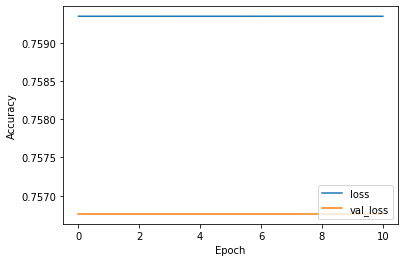

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

In [42]:
out = model(wap_img[10].reshape((1,50,50,1)))

In [43]:
out, output[10]

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 array([-0.87173432]))